### Necessary Libraries

In [1]:
import numpy as np
import pandas as pd

In [2]:
from scipy.stats import zscore

In [3]:
from scipy.cluster.vq import vq
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage

In [4]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
from warnings import filterwarnings
filterwarnings('ignore')

### Initial Exploration

In [7]:
df = pd.read_csv("marketing_data.csv")
df.head()

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping
0,19.94,16.92,0.8752,6.675,3.763,3.252,6.550
1,15.99,14.89,0.9064,5.363,3.582,3.336,5.144
2,18.95,16.42,0.8829,6.248,3.755,3.368,6.148
3,10.83,12.96,0.8099,5.278,2.641,5.182,5.185
4,17.99,15.86,0.8992,5.890,3.694,2.068,5.837


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   spending                      210 non-null    float64
 1   advance_payments              210 non-null    float64
 2   probability_of_full_payment   210 non-null    float64
 3   current_balance               210 non-null    float64
 4   credit_limit                  210 non-null    float64
 5   min_payment_amt               210 non-null    float64
 6   max_spent_in_single_shopping  210 non-null    float64
dtypes: float64(7)
memory usage: 11.6 KB


In [9]:
# summary of the data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
spending,210.0,14.847524,2.909699,10.5900,12.27000,14.35500,17.305000,21.1800
advance_payments,210.0,14.559286,1.305959,12.4100,13.45000,14.32000,15.715000,17.2500
probability_of_full_payment,210.0,0.870999,0.023629,0.8081,0.85690,0.87345,0.887775,0.9183
current_balance,210.0,5.628533,0.443063,4.8990,5.26225,5.52350,5.979750,6.6750
credit_limit,210.0,3.258605,0.377714,2.6300,2.94400,3.23700,3.561750,4.0330
min_payment_amt,210.0,3.700201,1.503557,0.7651,2.56150,3.59900,4.768750,8.4560
max_spent_in_single_shopping,210.0,5.408071,0.491480,4.5190,5.04500,5.22300,5.877000,6.5500


In [10]:
# duplicate records check
df.duplicated().sum()

0

In [11]:
# null value check
df.isnull().sum()

spending                        0
advance_payments                0
probability_of_full_payment     0
current_balance                 0
credit_limit                    0
min_payment_amt                 0
max_spent_in_single_shopping    0
dtype: int64

-------------

### Performing EDA 

In [12]:
# static method to visualize distribution
def distribution(x):
    fig,ax = plt.subplots(1,2,figsize=(12,4))
    sns.histplot(df[x], bins=20, ax=ax[0])
    ax[0].set_title('Distribution of {}'.format(x), fontsize=15)
    sns.boxplot(df[x], color='orange', ax=ax[1])
    ax[1].set_title('Boxplot of {}'.format(x), fontsize=15)
    plt.tight_layout()

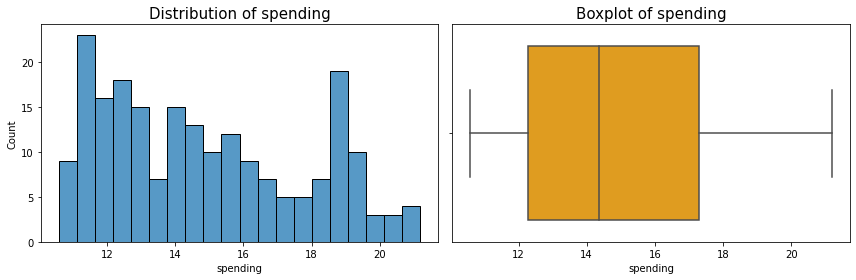

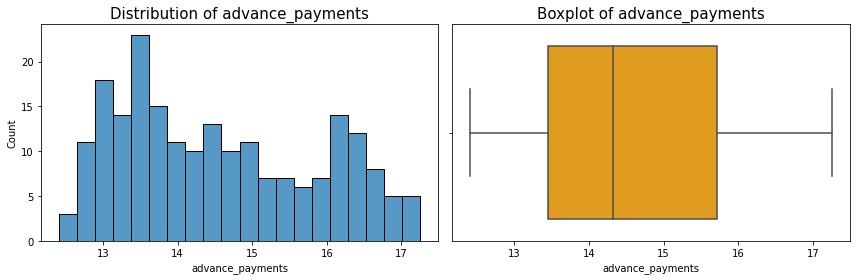

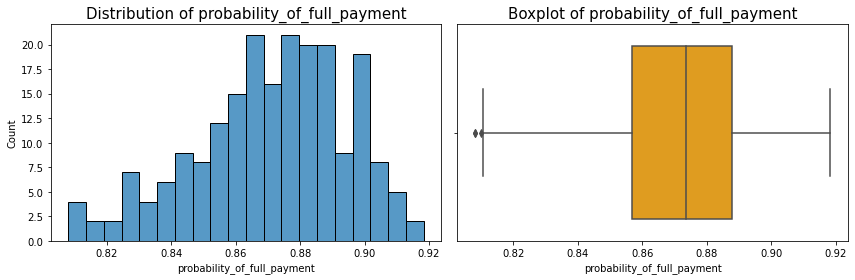

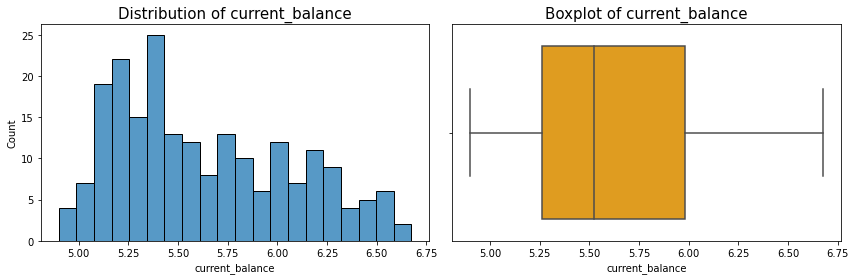

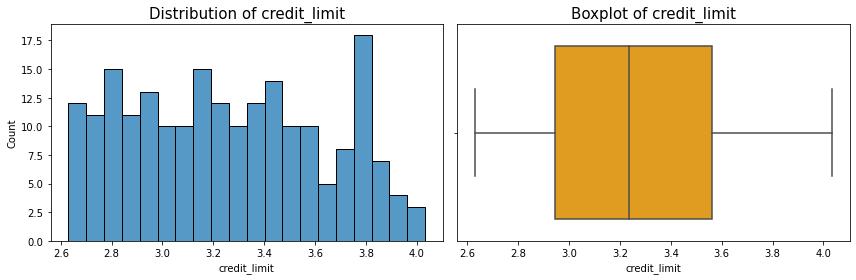

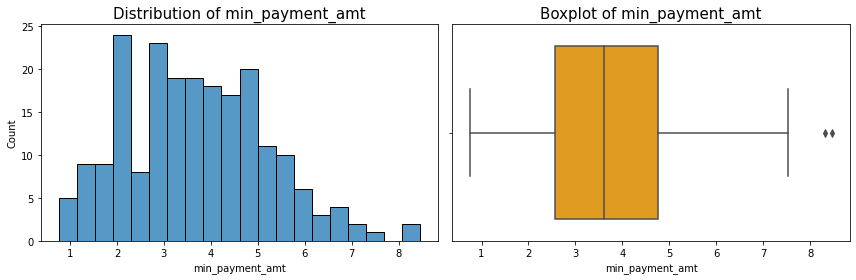

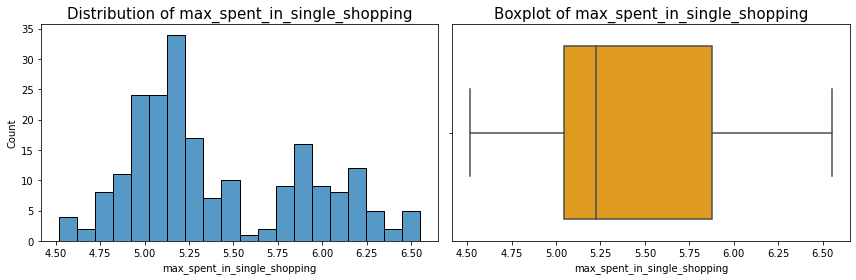

In [13]:
for i in df.columns:
    distribution(i)

**Obeservations:**

- Variables like probability_of_full_payment and min_payment_amount have few outlier points.
- None of the features follow an ideal normal distribution. Most of the features are right skewed in nature.
- Outliers affects the clustering process so we need to treat them accordingly.

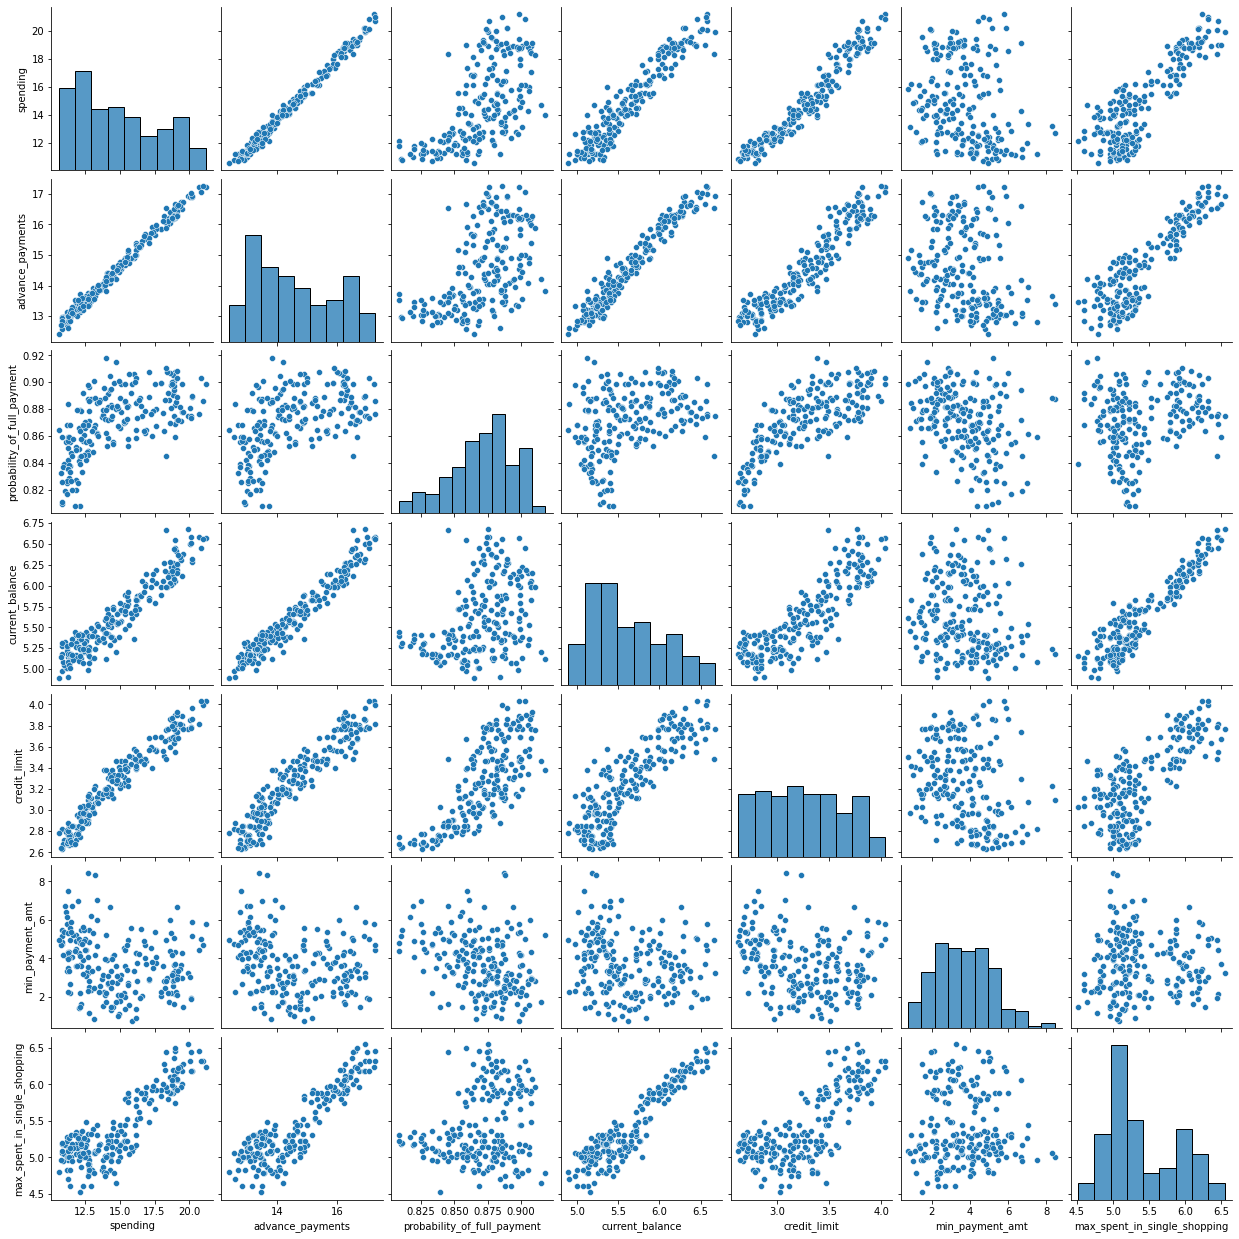

In [14]:
# pairplot
sns.pairplot(df);

**Observations:**

- We can see positive linear relationship between several variables in the dataset.
- Variables like spending vs advance_payment, current_balance vs advance_payment, spending vs current_balance and spending vs credit limit are showing strong linear positive relationship between them.
- In order to quantify their relationship, we have to look at the correlation heatmap.

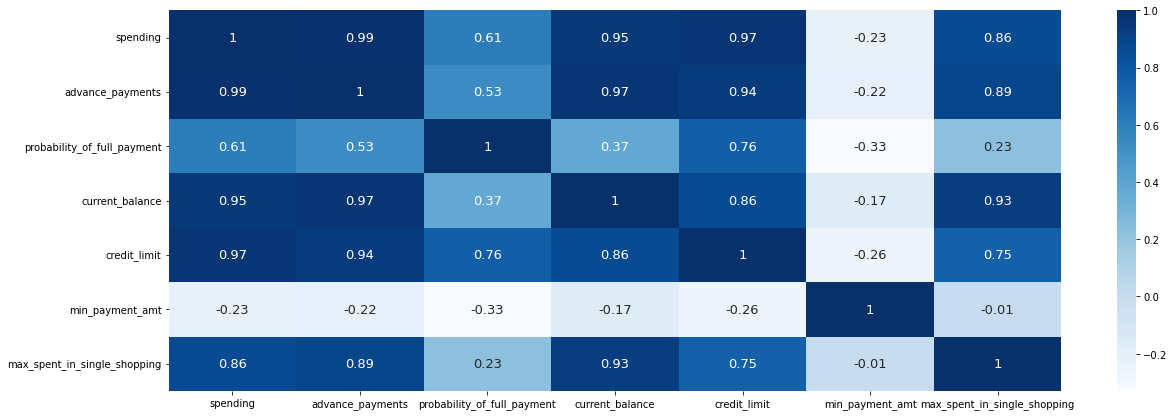

In [15]:
# correlation heatmap
correlation = np.round(df.corr(),2)

plt.figure(figsize=(20,7))
sns.heatmap(correlation, annot=True, annot_kws={'size':13}, cmap="Blues");
plt.show()

Observations:

- Highest positive correlation exists between spending and advance_payments which is 0.99.
- spending vs credit_limit and advance_payments vs current_balance has correlation coefficient of 0.97.
- spending vs current_balance and current_balance bs max_spent_in_single_shopping also have high correlation coefficient values.

-----------

### Treating Outliers

In [16]:
# upper and lower bound values
def finding_range(x):
    xs = pd.Series(sorted(x))
    Q3 = xs.quantile(q=0.75)
    Q1 = xs.quantile(q=0.25)
    IQR = Q3-Q1
    lower_range = Q1-(1.5*IQR)
    upper_range = Q3+(1.5*IQR)
    return lower_range, upper_range

In [17]:
# treating outliers
outliers = ["probability_of_full_payment","min_payment_amt"]

for i in outliers:
    LR,UR = finding_range(df[i])
    df[i] = np.where(df[i]>UR, UR, df[i])
    df[i] = np.where(df[i]<LR, LR, df[i])

----------

### Necessity of Scaling the Data

- The variables in the dataset have different range of values. Example: variables like spending, current_balance are in the range of few thousands, variable credit_limit is in the range of few ten thousands and data set also has the variable probability_of_full_payment which has decimal or fractional values.

- Clustering is a distance based algorithm which will be affected by datapoints which has higher weights. If unscaled data is used to cluster the records, the segmentation will not be appropriate.

- So, scaling is absolutely necessary for clustering algorithms. Scaling can be done using Z-Score or Standard Scaler methods.

In [18]:
# scaling the original data using standard scaler
scaler = StandardScaler()
data = scaler.fit_transform(df)

In [19]:
# creating a scaled dataframe
df_scaled = pd.DataFrame(data, columns=df.columns)
df_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
spending,210.0,9.148766e-16,1.002389,-1.466714,-0.887955,-0.169674,0.846599,2.181534
advance_payments,210.0,1.097006e-16,1.002389,-1.649686,-0.851433,-0.183664,0.887069,2.065260
probability_of_full_payment,210.0,1.642601e-15,1.002389,-2.571391,-0.600968,0.103172,0.712647,2.011371
current_balance,210.0,-1.089076e-16,1.002389,-1.650501,-0.828682,-0.237628,0.794595,2.367533
credit_limit,210.0,-2.994298e-16,1.002389,-1.668209,-0.834907,-0.057335,0.804496,2.055112
min_payment_amt,210.0,1.512018e-16,1.002389,-1.966425,-0.761698,-0.065915,0.718559,2.938945
max_spent_in_single_shopping,210.0,-1.935489e-15,1.002389,-1.813288,-0.740495,-0.377459,0.956394,2.328998


In [20]:
# variances comparison

# unscaled data variance
unscaled_summary = df.describe().T
unscaled_var = np.round((unscaled_summary["std"])**2,2)

# scaled data variance
scaled_summary = df_scaled.describe().T
scaled_var = np.round((scaled_summary["std"])**2,2)

In [21]:
# variance dataframe
variance = pd.concat([unscaled_var,scaled_var], axis=1)
variance.columns = ["Unscaled Variance", "Scaled Variance"]
print(variance)

                              Unscaled Variance  Scaled Variance
spending                                   8.47              1.0
advance_payments                           1.71              1.0
probability_of_full_payment                0.00              1.0
current_balance                            0.20              1.0
credit_limit                               0.14              1.0
min_payment_amt                            2.23              1.0
max_spent_in_single_shopping               0.24              1.0


---------

### Hierarchical Clustering

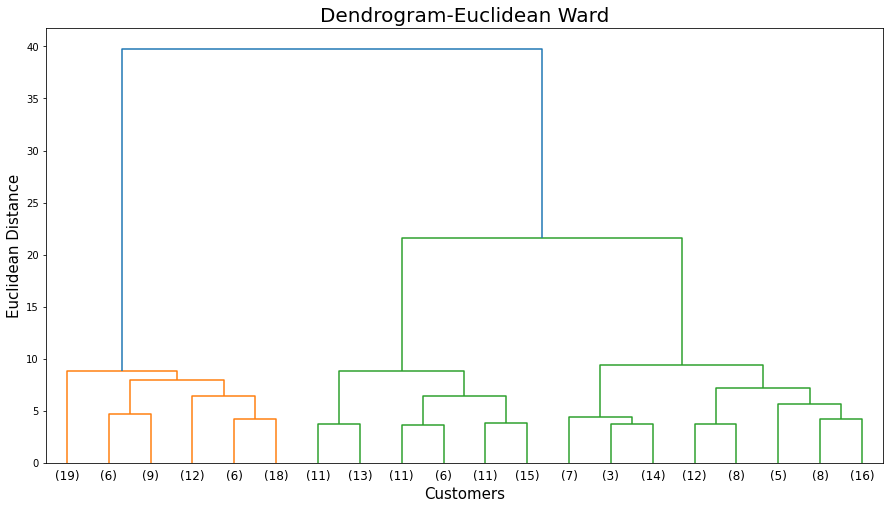

In [22]:
# using ward linkage and truncading upto 20 passes
wlink = linkage(df_scaled, method="ward", metric='euclidean')

# clustering
plt.figure(figsize=(15,8))
clusters = dendrogram(wlink, truncate_mode="lastp", p=20)

# plot
plt.title("Dendrogram-Euclidean Ward", fontsize=20);
plt.xlabel("Customers", fontsize=15)
plt.ylabel("Euclidean Distance", fontsize=15)
plt.show()

In [23]:
# two optimal clusters

labels_2 = fcluster(wlink, 25, criterion="distance")      # labels for 2 clusters
labels_3 = fcluster(wlink, 15, criterion="distance")      # labels for 3 clusters

In [24]:
# checking whether the clustering is done properly or not
# using principal components for visualization

from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=123)
pca_transformed = pca.fit_transform(df_scaled)

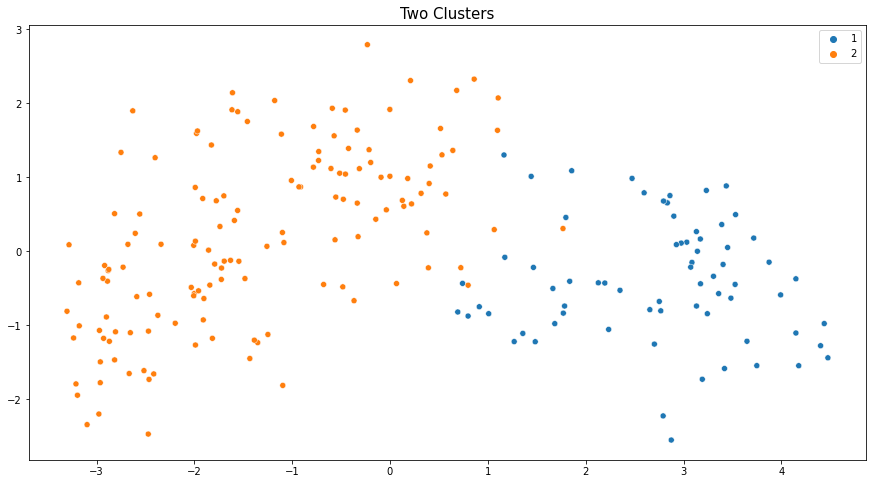

In [25]:
# pca scatterplot for two clusters
plt.figure(figsize=(15,8))
plt.title("Two Clusters", fontsize=15)
sns.scatterplot(x=pca_transformed[:,0],
                y=pca_transformed[:,1],
                hue=labels_2, palette="tab10")
plt.show()

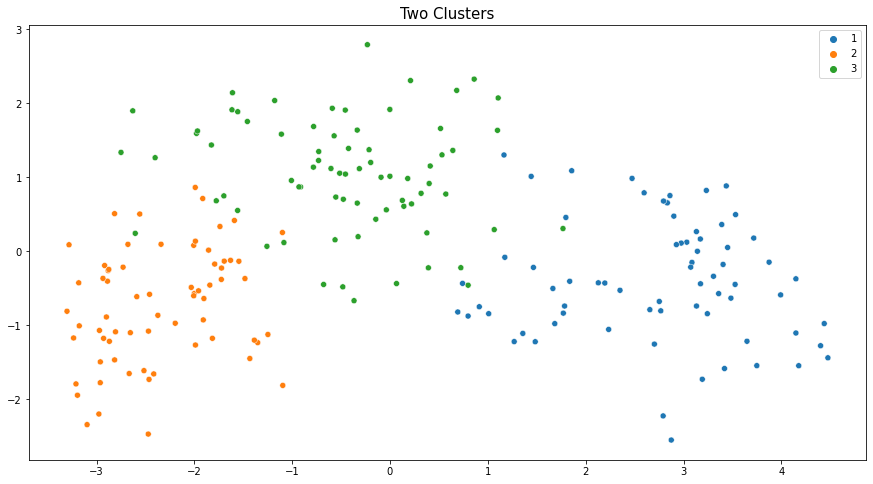

In [26]:
# pca scatterplot for three clusters
plt.figure(figsize=(15,8))
plt.title("Two Clusters", fontsize=15)
sns.scatterplot(x=pca_transformed[:,0],
                y=pca_transformed[:,1],
                hue=labels_3, palette="tab10")
plt.show()

Inferences:

- Taking two clusters might not be useful and does not provide any useful business insights in this case as there are different categories of people with different spending behavior. 
- We can group the customers into three clusters with very few customers scattered into other clusters. So, considering three clusters as an optimum number is reasonable and appropriate.

### Final Clusters

In [27]:
# attaching the labels to the cluster
df["cluster"] = labels_3
df.head()

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping,cluster
0,19.94,16.92,0.875200,6.675,3.763,3.252,6.550,1
1,15.99,14.89,0.906400,5.363,3.582,3.336,5.144,3
2,18.95,16.42,0.882900,6.248,3.755,3.368,6.148,1
3,10.83,12.96,0.810588,5.278,2.641,5.182,5.185,2
4,17.99,15.86,0.899200,5.890,3.694,2.068,5.837,1


In [28]:
# cluster wise averages for different features
cluster_grp = df.groupby("cluster").mean()
cluster_stats = np.round(cluster_grp,2)
print(cluster_stats.T)

cluster                           1      2      3
spending                      18.37  11.87  14.20
advance_payments              16.15  13.26  14.23
probability_of_full_payment    0.88   0.85   0.88
current_balance                6.16   5.24   5.48
credit_limit                   3.68   2.85   3.23
min_payment_amt                3.64   4.94   2.61
max_spent_in_single_shopping   6.02   5.12   5.09


Insights:

- Customers belong to cluster 1 are spending more, making more advance payments and having high credit limits on an average. Cluster 1 customers are more likely to be higher income group or economically more stable customers.
- Customers belong to cluster 2 are spending less, making low advance payments and having low credit limit on an average. These customers are more likely to be lower income group or may be economically less stable customers.
- Customers belong to cluster 3 seem to be spending higher than cluster 3 customers but lesser than cluster 1 customers.
- The minimum payment amount is very small for cluster 3 customers when compared to others. The maximum amount spent in a single shopping by the customers of cluster 2 and 3 are more or less same.

------------

### K-Means Clustering

In [29]:
# lets take 10 k values and compute wss
wss = []
for i in range(1,10):
    KM = KMeans(n_clusters=i, random_state=123).fit(df_scaled)
    wss.append(KM.inertia_)

In [30]:
# lets take 10 k values and compute silhouette scores
ss = []
for i in range(2,10):
    KM = KMeans(n_clusters=i, random_state=123).fit(df_scaled)
    score = silhouette_score(df_scaled,KM.labels_)
    ss.append(score)

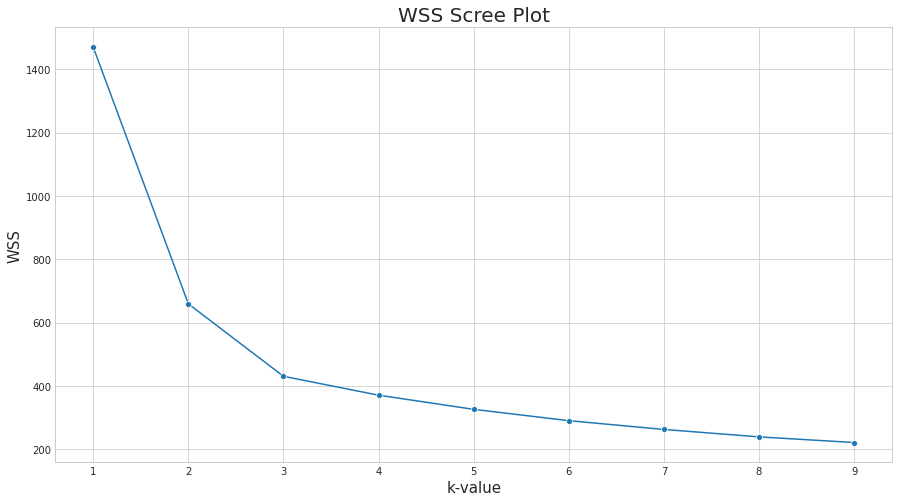

In [31]:
# wss plot or distortion plot

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(15,8))
    sns.lineplot(x=range(1,10), y=wss, marker='o')
    plt.title("WSS Scree Plot", fontsize=20)
    plt.xlabel("k-value", fontsize=15)
    plt.ylabel("WSS", fontsize=15)

In [32]:
# appending ss initial value (for k=1) also
shilhouette_scores = [0]

for i in ss:
    shilhouette_scores.append(i)

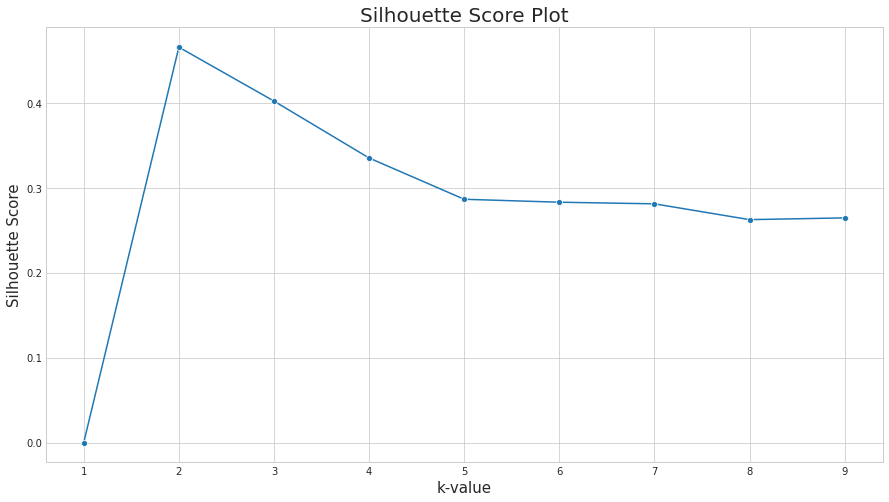

In [33]:
# silhouette score plot

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(15,8))
    sns.lineplot(x=range(1,10), y=shilhouette_scores, marker='o')
    plt.title("Silhouette Score Plot", fontsize=20)
    plt.ylabel("Silhouette Score", fontsize=15)
    plt.xlabel("k-value", fontsize=15)

In [34]:
# lets check the differences in inertia
difference = []

for i in range(0,len(wss)-1):
    diff = wss[i]-wss[i+1]
    difference.append(round(diff,2))
    
index = ["Between 1 & 2","Between 2 & 3","Between 3 & 4","Between 4 & 5",
         "Between 5 & 6","Between 6 & 7","Between 7 & 8","Between 8 & 9"]

Difference = pd.DataFrame(difference, columns=["WSS Difference"], index=index)
print(Difference)

               WSS Difference
Between 1 & 2          810.85
Between 2 & 3          228.86
Between 3 & 4           59.59
Between 4 & 5           44.75
Between 5 & 6           35.80
Between 6 & 7           27.73
Between 7 & 8           23.45
Between 8 & 9           17.87


In [35]:
# computing SSB and SSW for different K-values

TSS = []
SSW = []
SSB = []
WSS = []

for i in range(2,6):
    x = KMeans(n_clusters=i).fit(df_scaled).cluster_centers_ 
    partition, euc_distance_to_centroids = vq(df_scaled, x) 
    
    wss_df = pd.DataFrame([euc_distance_to_centroids**2,KMeans(n_clusters=i).fit(df_scaled).labels_]).T
    sep_wss = np.round(wss_df.groupby(1).sum().values,2)
                       
    tss = round(np.sum(((df_scaled-df_scaled.mean())**2).sum()),2)
    ssw = round(np.sum(euc_distance_to_centroids**2),2) 
    ssb = tss-ssw
    
    TSS.append(tss)
    SSW.append(ssw)
    SSB.append(ssb)
    WSS.append(sep_wss)

In [36]:
# creating a seperate dataframe

indx = ["k=2","k=3","k=4","k=5"]
cols = ["TSS","SSW","SSB","Cluster WSS"]

temp = pd.concat([pd.Series(TSS),pd.Series(SSW),pd.Series(SSB),
                  pd.Series(WSS)],axis=1, ignore_index=True)

temp.columns = cols
temp.index = indx
print(temp)

        TSS     SSW      SSB                                  Cluster WSS
k=2  1470.0  659.15   810.85                         [[461.13], [198.02]]
k=3  1470.0  430.30  1039.70               [[143.57], [140.89], [145.84]]
k=4  1470.0  370.87  1099.13       [[113.93], [86.93], [50.61], [119.39]]
k=5  1470.0  327.72  1142.28  [[65.6], [78.97], [83.31], [37.1], [62.75]]


Observations:

- For k=3, the difference between SSB and SSW is higher than that of K=2.
- For k=4 ther is only small increase in difference between SSB and SSW than k=3 values.
- Compared to K=2, 3 clusters have very good seperation and SSB value.

In [37]:
# lets take 3 clusters and analyze them
KM = KMeans(n_clusters=3, random_state=123).fit(df_scaled)

In [38]:
# generate the labels and attach it to the df

labels = KM.labels_

In [39]:
# lets attach the labels

df["cluster"] = labels
df.head()

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping,cluster
0,19.94,16.92,0.875200,6.675,3.763,3.252,6.550,0
1,15.99,14.89,0.906400,5.363,3.582,3.336,5.144,2
2,18.95,16.42,0.882900,6.248,3.755,3.368,6.148,0
3,10.83,12.96,0.810588,5.278,2.641,5.182,5.185,1
4,17.99,15.86,0.899200,5.890,3.694,2.068,5.837,0


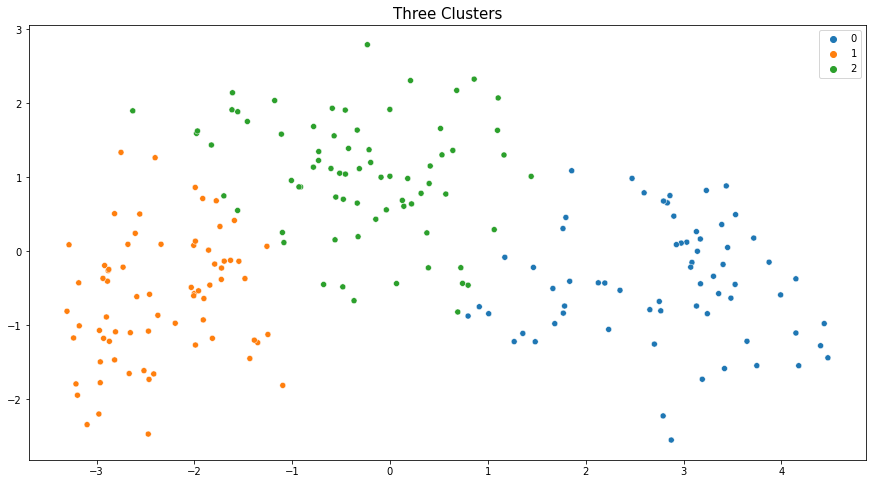

In [40]:
# checking the clusters

plt.figure(figsize=(15,8))
plt.title("Three Clusters", fontsize=15)
sns.scatterplot(x=pca_transformed[:,0],
                y=pca_transformed[:,1],
                hue=labels,palette="tab10")
plt.show()

Observations:

- Here the clusters are well seperated when compared to agglomerative clustering as we don't have any datapoints scattered over other clusters.

- Hence we take 3 as optimal number of clusters in this business case.

In [41]:
# lets check the average values of different variables for different clusters
# cluster wise analysis

cluster_grp = df.groupby("cluster").mean()
cluster_stats = np.round(cluster_grp,3)
print(cluster_stats.T)

cluster                            0       1       2
spending                      18.495  11.866  14.393
advance_payments              16.203  13.256  14.314
probability_of_full_payment    0.884   0.848   0.882
current_balance                6.176   5.236   5.506
credit_limit                   3.698   2.849   3.254
min_payment_amt                3.632   4.769   2.701
max_spent_in_single_shopping   6.042   5.107   5.115


Insights:

- Customers belong to cluster 0 are spending more, making more advance payments and having high credit limits on an average. Cluster 0 customers are more likely to be higher income group or economically more stable customers.
- Customers belong to cluster 1 are spending less, making low advance payments and having low credit limit on an average. These customers are more likely to be lower income group or may be economically less stable customers.
- Customers belong to cluster 2 seem to be spending higher than cluster 1 customers but lesser than cluster 0 customers.
- The minimum payment amount is very small for cluster 2 customers when compared to others. The maximum amount spent in a single shopping by the customers of cluster 1 and 2 are more or less same.
- The probability of full payment is approximately equal for customers belonging to cluster 0 and cluster 2.

### Recommendations

Let us take some important features like spending, credit limit, minimum payment amount and advance payments variables to make recommendations for different clusters. Let us consider the clusters obtained from hierarchical clustering technique.

**Recommendations for Cluster 1 and 3**
- Customers in cluster 1 and 3 seem to have high credit limit, high spending capability in a single shopping and making more advance payments.
- These customers must be using their credit cards more frequently and probability of full payment is also high. For these customers we can provide premium credit cards services with more benefits, perks, rewards, club memberships and gift vouchers.

**Recommendations for Cluster 2**
- Customers in cluster 2 seem to have lower credit limit, lower spending, lower advance payments but capable of making high minimum payment than other clusters.
- These customers seem to use their credit cards rarely for purchases. To make them use their credit cards more frequently, customers can be provided with loans, recommended to make small minimum payments and make payments on time so that they may increase their credit limit and can spend more.

----------